In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data
train = pd.read_csv("/kaggle/input/playground-series-s5e6/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e6/test.csv")

# Clean and normalize column names
train.columns = [col.strip().lower().replace(" ", "_") for col in train.columns]
test.columns = [col.strip().lower().replace(" ", "_") for col in test.columns]

In [6]:
train.head()

,id,temparature,humidity,moisture,soil_type,crop_type,nitrogen,potassium,phosphorous,fertilizer_name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [5]:
test.head()

,id,temparature,humidity,moisture,soil_type,crop_type,nitrogen,potassium,phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4
3,750003,37,53,57,Black,Ground Nuts,18,17,36
4,750004,31,55,32,Red,Pulses,13,19,14


In [8]:
# Categorical encoding
cat_cols = ['soil_type','crop_type']
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

#Target encoding
fertilizer_le = LabelEncoder()
train['fertilizer_name'] = fertilizer_le.fit_transform(train['fertilizer_name'])

In [9]:
train.columns

Index(['id', 'temparature', 'humidity', 'moisture', 'soil_type', 'crop_type',
       'nitrogen', 'potassium', 'phosphorous', 'fertilizer_name'],
      dtype='object')

In [10]:
# Features and target
features = ['temparature', 'humidity', 'moisture', 'soil_type', 'crop_type',
       'nitrogen', 'potassium', 'phosphorous']

target = 'fertilizer_name'

In [11]:
X = train[features]
y = train[target]

X_test = test[features]

In [12]:
# Train/validation split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [14]:
# Hyperparameter tuning
param_grid = {
    'learning_rate' : [0.05],
    'num_leaves' : [31],
    'n_estimators' : [200],
    'max_depth' : [-1]
}

In [16]:
clf = lgb.LGBMClassifier(objective='multiclass',num_classes=len(np.unique(y)),random_state=42)
grid = GridSearchCV(clf,param_grid,scoring='accuracy',cv=3)
grid.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 8
[LightGBM] [Info] Start training from score -1.884862
[LightGBM] [Info] Start training from score -1.880050
[LightGBM] [Info] Start training from score -1.897537
[LightGBM] [Info] Start training from score -1.911557
[LightGBM] [Info] Start training from score -1.909125
[LightGBM] [Info] Start training from score -2.067671
[LightGBM] [Info] Start training from score -2.094839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] 

GridSearchCV(cv=3,
             estimator=LGBMClassifier(num_classes=7, objective='multiclass',
                                      random_state=42),
             param_grid={'learning_rate': [0.05], 'max_depth': [-1],
                         'n_estimators': [200], 'num_leaves': [31]},
             scoring='accuracy')

In [17]:
model = grid.best_estimator_
print("Best Params:",grid.best_params_)

Best Params: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31}


In [18]:
# MAP@3 Function
def mapk(y_true, y_pred, k=3):
    score = 0.0
    for actual, pred in zip(y_true, y_pred):
        try:
            rank = pred.index(actual) + 1
            score += 1.0 / rank
        except ValueError:
            continue
    return score / len(y_true)

# Evaluate on validation set
val_probs = model.predict_proba(X_val)
val_top3 = np.argsort(val_probs, axis=1)[:, -3:][:, ::-1]
val_pred_top3 = [list(row) for row in val_top3]
val_score = mapk(y_val.tolist(), val_pred_top3)
print(f"📊 Validation MAP@3: {round(val_score, 4)}")

# Predict on test set
test_probs = model.predict_proba(X_test)
test_top3 = np.argsort(test_probs, axis=1)[:, -3:][:, ::-1]

📊 Validation MAP@3: 0.3222


In [20]:
# Convert to fertilizer names
top3_names = [" ".join(fertilizer_le.inverse_transform(row)) for row in test_top3]
# Submission file
submission = pd.DataFrame({
    'id': test['id'],
    'Fertilizer Name': top3_names
})
submission.to_csv('submission.csv', index=False)
print("📁 Submission file saved as 'submission.csv'")

📁 Submission file saved as 'submission.csv'


/tmp/ipykernel_80/1771623274.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


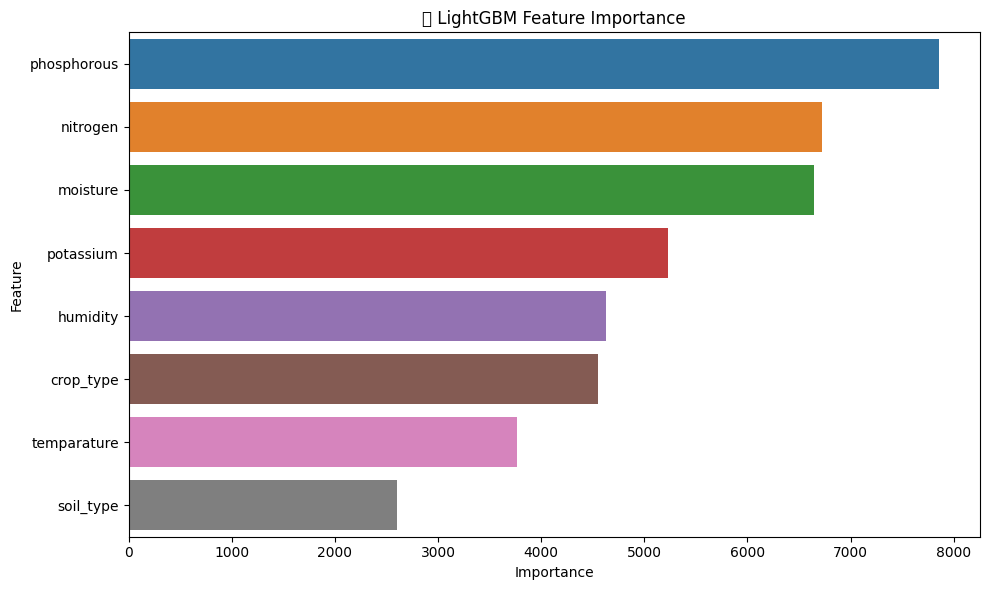

In [21]:
# Plot feature importance
def plot_importance(model, feature_names):
    importance = model.feature_importances_
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    imp_df = imp_df.sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=imp_df, x='Importance', y='Feature')
    plt.title("📊 LightGBM Feature Importance")
    plt.tight_layout()
    plt.show()

plot_importance(model, features)